# Домашнее задание:
## Сравнение детекторов на примере детекции игроков в спорте

Необходимо обучить на целевом датасете (игроки в спорте) два типа детекторов: 1) Detectron2 (семейтсво R-CNN) и 2) Ultralytics (семейство YOLO). После обучения нужно замерить метрику mAP для разных моделей и сравнить результаты. Задание будет принятно только после выполнения всех 5 задач. Также необходимо продемонстрировать код и сводную таблицу с результатами.

### Задачи:
1) Обучить любую модель из [Detectron2](https://github.com/facebookresearch/detectron2) детектировать игроков в баскетбольном матче. Число классов: 2 (две команды). В качестве начальной модели взять любую из [предобученных моделей](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) (Faster R-CNN или RetinaNet). Перед обучением, необходимо привести целевой датасет к формату detectron2. Пример того, как обучать Detectron2 на своем датасете можно найти [здесь](https://colab.research.google.com/drive/1Xdm2KrBauT0lEyKFEiLie7nhzXajgEkH?usp=sharing). Посчитать метрику COCO mAP.

2) Обучить любую модель из [Ultralytics](https://github.com/ultralytics/ultralytics) (YOLOv8, YOLOv9, YOLOv10). В качестве начальной модели необходимо взять предобученную модель (например, yolov8n.pt). Необходимо также адаптировать целевой датасет к формату Ultralytics. Пример того, как обучить YOLOv8 на своем датасете можно найти [здесь](https://colab.research.google.com/drive/1fPZT1d-EBuYdDgXAmfnlKhkFilRnrjGj?usp=sharing). Посчитать метрику COCO mAP.

3) Обучить модель из Ultralytics с нуля (from scratch), аналогично п.2.

4) Протестировать модель "из коробки" из Ultralytics (т.е. без дообучения) и посчитать mAP для тестовой выборки.

5) Свести в единую таблицу результаты всех моделей (по метрике mAP), сравнить и сделать выводы (точность, скорость обучения, эффект предобучения, удобство работы с фреймворком (detectron2 и ultralitics).

### Датасет:
Скачайте датасет [otus_basketball_dataset](https://disk.yandex.ru/d/thdvaAKQS3ASXA) и распакуйте. Внутри находятся папки `images_train` (400 изображений) и `images_test` (100 изображений), а также файлы с аннотациями к ним: `anno_train.json` и `anno_test.json`. Файлы с аннотациями имеет следующую структуру:
```
image_name: {
     player_id: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
}
....
```
Здесь `image_name` - имя изображения в соответствующей папке,<br>
`player_id` - id игрока в текущем изображении (в данном задании id не важен),<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).

In [2]:
import torch
print(torch.__version__)  
print(torch.cuda.is_available())

2.7.0+cu128
True


In [84]:
%matplotlib inline
import ultralytics
import json
import os
from pathlib import Path
import shutil
from ultralytics import YOLO
import os
import cv2
import yaml
import random
import matplotlib.pyplot as plt
ultralytics.checks()

from IPython.display import Image

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Setup complete  (16 CPUs, 27.7 GB RAM, 816.8/951.6 GB disk)


In [27]:
# Пути к данным
DATA_DIR = "Data"
IMAGES_TRAIN_DIR = os.path.join(DATA_DIR, "images_train")
IMAGES_TEST_DIR = os.path.join(DATA_DIR, "images_test")
ANNO_TRAIN_PATH = os.path.join(DATA_DIR, "anno_train.json")
ANNO_TEST_PATH = os.path.join(DATA_DIR, "anno_test.json")

# Пути для сохранения разметки
LABELS_TRAIN_DIR = os.path.join(DATA_DIR, "labels_train")
LABELS_TEST_DIR = os.path.join(DATA_DIR, "labels_test")

# Создаем папки для разметки
os.makedirs(LABELS_TRAIN_DIR, exist_ok=True)
os.makedirs(LABELS_TEST_DIR, exist_ok=True)

In [28]:
def convert_annotations(anno_path, images_dir, labels_dir):
    with open(anno_path, 'r') as f:
        annotations = json.load(f)

    for img_name, objects in annotations.items():
        # Путь к .txt файлу
        label_file = os.path.join(labels_dir, os.path.splitext(img_name)[0] + ".txt")
        
        # Проверяем, существует ли изображение
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Изображение {img_name} не найдено в {images_dir}. Пропускаем.")
            continue
        
        # Записываем bounding box'ы
        with open(label_file, 'w') as f:
            for obj_id, data in objects.items():
                team = data['team']
                box = data['box']  # [x_center, y_center, width, height]

                # Проверяем, что все значения в диапазоне [0, 1]
                if any(not (0 <= x <= 1) for x in box):
                    print(f"Некорректные координаты в {img_name}, объект {obj_id}. Пропускаем.")
                    continue

                # Формат YOLO: class_id x_center y_center width height
                line = f"{team} {' '.join(map(str, box))}\n"
                f.write(line)

# Обработка train и test
convert_annotations(ANNO_TRAIN_PATH, IMAGES_TRAIN_DIR, LABELS_TRAIN_DIR)
convert_annotations(ANNO_TEST_PATH, IMAGES_TEST_DIR, LABELS_TEST_DIR)

print("Разметка успешно преобразована!")

Некорректные координаты в 020017.jpeg, объект 2. Пропускаем.
Некорректные координаты в 020017.jpeg, объект 15. Пропускаем.
Некорректные координаты в 029147.jpeg, объект 2. Пропускаем.
Некорректные координаты в 037892.jpeg, объект 15. Пропускаем.
Некорректные координаты в 040007.jpeg, объект null. Пропускаем.
Некорректные координаты в 040155.jpeg, объект 1. Пропускаем.
Некорректные координаты в 047533.jpeg, объект 31. Пропускаем.
Некорректные координаты в 055446.jpeg, объект 0. Пропускаем.
Некорректные координаты в 081921.jpeg, объект 20. Пропускаем.
Некорректные координаты в 094774.jpeg, объект 2. Пропускаем.
Разметка успешно преобразована!


In [73]:
# Пути к данным
IMAGES_DIR = "dataset/images/train"  # Папка с изображениями
LABELS_DIR = "dataset/labels/train"  # Папка с .txt файлами

# Имена классов (в порядке class_id)
CLASS_NAMES = ['team0', 'team1']
CLASS_COLORS = [(0, 255, 0), (255, 0, 0)]  # team0 - зеленый, team1 - синий

In [105]:
def draw_bounding_boxes(image_path, label_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    if image is None:
        print(f"Не удалось загрузить изображение {image_path}")
        return None

    h, w, _ = image.shape

    # Рисование bounding box'ов
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Переводим нормализованные координаты в пиксели
            x1 = int(x_center * w)
            y1 = int(y_center * h)
            x2 = int((x_center + width) * w)
            y2 = int((y_center + height) * h)

            color = CLASS_COLORS[class_id]
            label = CLASS_NAMES[class_id]

            # Рисуем bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            
            # Подпись класса
            cv2.putText(image, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    else:
        print(f"Файл аннотации {label_path} не найден!")

    return image

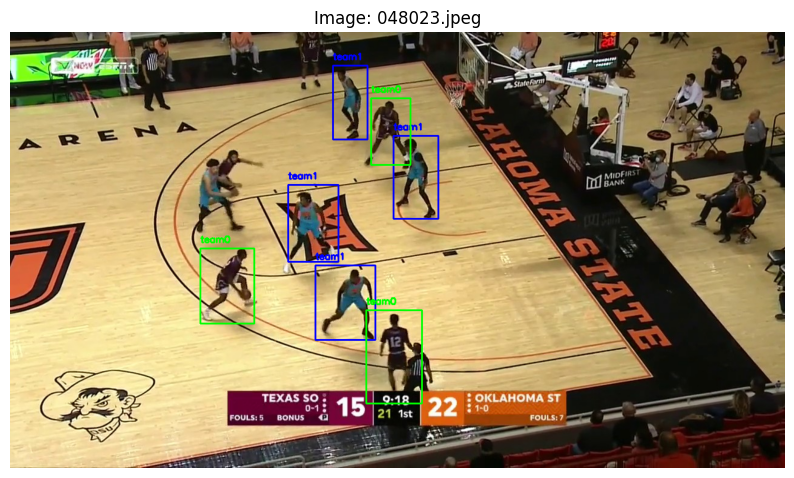

In [107]:
# Получаем список изображений
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]

if not image_files:
    print("Нет изображений в указанной папке.")
else:
    # Выбираем случайное изображение
    random_image_file = random.choice(image_files)
    image_path = os.path.join(IMAGES_DIR, random_image_file)
    label_path = os.path.join(LABELS_DIR, os.path.splitext(random_image_file)[0] + ".txt")

    # Рисуем bounding box'ы
    annotated_image = draw_bounding_boxes(image_path, label_path)

    if annotated_image is not None:
        # Преобразуем из BGR в RGB для matplotlib
        annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        # Отображаем изображение через matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(annotated_image)
        plt.title(f"Image: {random_image_file}")
        plt.axis("off")
        plt.show()

In [108]:
# Загрузите модель
model = YOLO("yolo11m.pt") 

In [111]:

# Обучение
model.train(
    data="Lesson 17/Homework/dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,  # 0 - первый GPU
    name="basketball_model"
)

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Lesson 17/Homework/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=basketball_model14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

RuntimeError: Dataset 'Lesson 17/Homework/dataset/data.yaml' error  'Lesson 17/Homework/dataset/data.yaml' does not exist

NameError: name 'image_files' is not defined

In [4]:
# Обучение модели
model = YOLO("yolo11m.pt")  # Загрузка предобученной модели

100%|██████████| 38.8M/38.8M [00:02<00:00, 15.4MB/s]


In [ ]:
results = model.train(
    data="C:/Users/khari/OneDrive/Документы/GirRep/OtusCV/Lesson 17/Homework/Data/otus_basketball_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.001,
    device= '0')